# Day x
batch size 256 lr 1e-3, normed weighted, non-rotated, cartesian, SWA renwal test

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
#os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 352447725380304422
]


## Options

In [3]:
classTrainFeatures = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']
classModel = 'modelSwish'
varSet = "basic_features"

nSplits = 10
ensembleSize = 10
ensembleMode = 'loss'

maxEpochs = 200
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs, 'mode':'classifier'}

print("\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(dirLoc + 'inputPipe.pkl', 'rb') as fin:
    inputPipe = pickle.load(fin)

In [5]:
trainData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'train.hdf5', "r+"),
                                    inputPipe=inputPipe, augRotMult=16)

## Determine LR

2 classes found, running in binary mode


______________________________________
Training finished
Cross-validation took 1.639s 


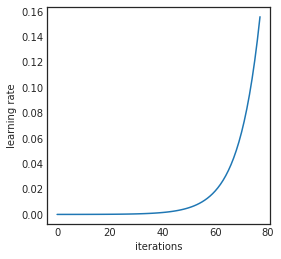

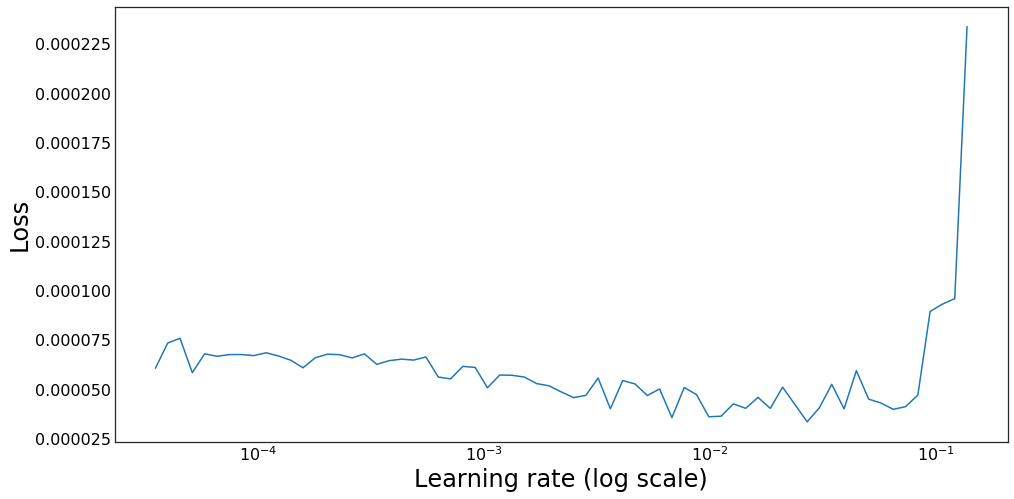

______________________________________



In [7]:
lrFinder = batchLRFind(trainData, getModel, modelParams, trainParams,
                       lrBounds=[1e-5,2e-1], trainOnWeights=True, verbose=0)

In [6]:
compileArgs['lr'] = 1e-3

In [7]:
def _batchTrainClassifier(batchYielder, nSplits, modelGen, modelGenParams, trainParams,
                         cosAnnealMult=0, reverseAnneal=False, plotLR=False, reduxDecay=False,
                         annealMomentum=False, reverseAnnealMomentum=False, plotMomentum=False,
                         oneCycle=False, ratio=0.25, reverse=False, lrScale=10, momScale=0.1, plotOneCycle=False, scale=30, mode='sgd',
                         swaStart=-1, swaRenewal=-1, sgdReplacement=False,
                         trainOnWeights=True,
                         saveLoc='train_weights/', patience=10, maxEpochs=10000,
                         verbose=False, logoutput=False):
    
    os.system("mkdir " + saveLoc)
    os.system("rm " + saveLoc + "*.h5")
    os.system("rm " + saveLoc + "*.json")
    os.system("rm " + saveLoc + "*.pkl")
    os.system("rm " + saveLoc + "*.png")
    os.system("rm " + saveLoc + "*.log")
    
    if logoutput:
        old_stdout = sys.stdout
        log_file = open(saveLoc + 'training_log.log', 'w')
        sys.stdout = log_file

    start = timeit.default_timer()
    results = []
    histories = []
    binary = None

    if not isinstance(batchYielder, BatchYielder):
        print ("HDF5 as input is depreciated, converting to BatchYielder")
        batchYielder = BatchYielder(batchYielder)

    if cosAnnealMult: print ("Using cosine annealing")
    if trainOnWeights: print ("Training using weights")

    for fold in range(nSplits):
        foldStart = timeit.default_timer()
        print ("Running fold", fold+1, "/", nSplits)
        os.system("rm " + saveLoc + "best.h5")
        best = -1
        bestLR = -1
        reduxDecayActive = False
        tmpPatience = patience
        epochCounter = 0
        subEpoch = 0
        stop = False
        lossHistory = {'val_loss':[], 'swa_val_loss':[]}
        trainID, testID = getFolds(fold, nSplits) #Get fold indeces for training and testing for current fold

        model = None
        model = modelGen(**modelGenParams)
        model.reset_states #Just checking
        
        testbatch = batchYielder.getBatch(testID) #Load testing fold

        callbacks = []
        if cosAnnealMult:
            cosAnneal = CosAnneal(math.ceil(len(batchYielder.source['fold_0/targets'])/trainParams['batch_size']), cosAnnealMult, reverseAnneal)
            callbacks.append(cosAnneal)
        
        if annealMomentum:
            cosAnnealMomentum = CosAnnealMomentum(math.ceil(len(batchYielder.source['fold_0/targets'])/trainParams['batch_size']), cosAnnealMult, reverseAnnealMomentum)
            callbacks.append(cosAnnealMomentum)    

        if oneCycle:
            oneCycle = OneCycle(math.ceil(len(batchYielder.source['fold_0/targets'])/trainParams['batch_size']), ratio=ratio, reverse=reverse, lrScale=lrScale, momScale=momScale, scale=scale, mode=mode)
            callbacks.append(oneCycle)  
        
        if swaStart >= 0:
            if cosAnnealMult:
                swa = _SWA(swaStart, testbatch, modelGen(**modelGenParams), verbose, swaRenewal, cosAnneal, trainOnWeights=trainOnWeights, sgdReplacement=sgdReplacement)
            else:
                swa = _SWA(swaStart, testbatch, modelGen(**modelGenParams), verbose, swaRenewal, trainOnWeights=trainOnWeights, sgdReplacement=sgdReplacement)
            callbacks.append(swa)
        useSWA = False

        for epoch in range(maxEpochs):
            for n in trainID: #Loop through training folds
                trainbatch = batchYielder.getBatch(n) #Load fold data
                subEpoch += 1
                
                if binary == None: #First run, check classification mode
                    binary = True
                    nClasses = len(np.unique(trainbatch['targets']))
                    if nClasses > 2:
                        print (nClasses, "classes found, running in multiclass mode\n")
                        trainbatch['targets'] = utils.to_categorical(trainbatch['targets'], num_classes=nClasses)
                        binary = False
                    else:
                        print (nClasses, "classes found, running in binary mode\n")

                if trainOnWeights:
                    model.fit(trainbatch['inputs'], trainbatch['targets'],
                              class_weight = 'auto', sample_weight=trainbatch['weights'],
                              callbacks = callbacks, **trainParams) #Train for one epoch

                    if swaStart >= 0 and swa.active:
                        losses = swa.get_losses()
                        print('{} swa loss {}, default loss {}'.format(subEpoch, losses['swa'], losses['base']))
                        if losses['swa'] < losses['base']:
                            loss = losses['swa']
                            useSWA = True
                        else:
                            loss = losses['base']
                            useSWA = False
                        
                    else:
                        loss = model.evaluate(testbatch['inputs'], testbatch['targets'], sample_weight=testbatch['weights'], verbose=0)
                    
                else:
                    model.fit(trainbatch['inputs'], trainbatch['targets'],
                              class_weight = 'auto',
                              callbacks = callbacks, **trainParams) #Train for one epoch
                    
                    if swaStart >= 0 and swa.active:
                        losses = swa.get_losses()
                        print('{} swa loss {}, default loss {}'.format(subEpoch, losses['swa'], losses['base']))
                        if losses['swa'] < losses['base']:
                            loss = losses['swa']
                            useSWA = True
                        else:
                            loss = losses['base']
                            useSWA = False
                    else:
                        loss = model.evaluate(testbatch['inputs'], testbatch['targets'], verbose=0)
                
                if swaStart >= 0 and swa.active and cosAnnealMult > 1:
                    print ("{} SWA loss:", subEpoch, loss)
                
                if swaStart >= 0:
                    if swa.active:
                        lossHistory['swa_val_loss'].append(losses['swa'])
                        lossHistory['val_loss'].append(losses['base'])
                    else:
                        lossHistory['swa_val_loss'].append(loss)
                        lossHistory['val_loss'].append(loss)
                else:
                    lossHistory['val_loss'].append(loss)        

                if loss <= best or best < 0: #Save best
                    best = loss
                    if cosAnnealMult:
                        if cosAnneal.lrs[-1] > 0:
                            bestLR = cosAnneal.lrs[-1]
                        else:
                            bestLR = cosAnneal.lrs[-2]
                    epochCounter = 0
                    if swaStart >= 0 and swa.active and useSWA:
                        swa.test_model.save_weights(saveLoc + "best.h5")
                    else:
                        model.save_weights(saveLoc + "best.h5")
                    if reduxDecayActive:
                        cosAnneal.lrs.append(float(K.get_value(model.optimizer.lr)))
                    if verbose:
                        print ('{} New best found: {}'.format(subEpoch, best))
                elif cosAnnealMult and not reduxDecayActive:
                    if cosAnneal.cycle_end:
                        epochCounter += 1
                else:
                    epochCounter += 1
                    if reduxDecayActive:
                        lr = 0.8*float(K.get_value(model.optimizer.lr))
                        cosAnneal.lrs.append(lr)
                        K.set_value(model.optimizer.lr, lr)

                if epochCounter >= tmpPatience: #Early stopping
                    if cosAnnealMult and reduxDecay and not reduxDecayActive:
                        print ('CosineAnneal stalling after {} epochs, entering redux decay at LR={}'.format(subEpoch, bestLR))
                        model.load_weights(saveLoc +  "best.h5")
                        cosAnneal.lrs.append(bestLR)
                        K.set_value(model.optimizer.lr, bestLR)
                        tmpPatience = 10
                        epochCounter = 0
                        callbacks = []
                        reduxDecayActive = True
                    else:
                        if verbose:
                            print ('Early stopping after {} epochs'.format(subEpoch))
                        stop = True
                        break
            
            if stop:
                break

        model.load_weights(saveLoc +  "best.h5")

        histories.append({})
        histories[-1]['val_loss'] = lossHistory['val_loss']
        if swaStart >= 0:
            histories[-1]['swa_val_loss'] = lossHistory['swa_val_loss']
        
        results.append({})
        results[-1]['loss'] = best
        if binary:
            testbatch = batchYielder.getBatch(testID) #Load testing fold
            if not isinstance(testbatch['weights'], type(None)):
                results[-1]['wAUC'] = 1-roc_auc_score(testbatch['targets'],
                                                     model.predict(testbatch['inputs'], verbose=0),
                                                     sample_weight=testbatch['weights'])
            results[-1]['AUC'] = 1-roc_auc_score(testbatch['targets'],
                                                 model.predict(testbatch['inputs'], verbose=0))
        print ("Score is:", results[-1])

        if plotLR: cosAnneal.plot_lr()
        if plotMomentum: cosAnnealMomentum.plot_momentum()
        if plotOneCycle: oneCycle.plot()

        print("Fold took {:.3f}s\n".format(timeit.default_timer() - foldStart))

        model.save(saveLoc +  'train_' + str(fold) + '.h5')
        with open(saveLoc +  'resultsFile.pkl', 'wb') as fout: #Save results
            pickle.dump(results, fout)

    print("\n______________________________________")
    print("Training finished")
    print("Cross-validation took {:.3f}s ".format(timeit.default_timer() - start))
    plotTrainingHistory(histories, save=saveLoc + 'loss_history.png')
    for score in results[0]:
        mean = uncertRound(np.mean([x[score] for x in results]), np.std([x[score] for x in results])/np.sqrt(len(results)))
        print ("Mean", score, "= {} +- {}".format(mean[0], mean[1]))
    print("______________________________________\n")
                      
    if logoutput:
        sys.stdout = old_stdout
        log_file.close()
    return results, histories

In [8]:
class _SWA(Callback):
    '''Based on fastai version'''
    def __init__(self, swa_start, testBatch, testModel, verbose=False, swaRenewal=-1,
                 clrCallback=None, trainOnWeights=False, sgdReplacement=False):
        super(_SWA, self).__init__()
        self.swa_model = None
        self.swa_model_new = None
        self.swa_start = swa_start
        self.epoch = -1
        self.swa_n = -1
        self.swaRenewal = swaRenewal
        self.n_since_renewal = -1
        self.losses = {'swa':None, 'base':None}
        self.active = False
        self.testBatch = testBatch
        self.weighted = trainOnWeights
        self.clrCallback = clrCallback
        self.test_model = testModel
        self.verbose = verbose
        self.sgdReplacement = sgdReplacement
        
    def on_train_begin(self, logs={}):
        if isinstance(self.swa_model, type(None)):
            self.swa_model = self.model.get_weights()
            self.swa_model_new = self.model.get_weights()
            self.epoch = 0
            self.swa_n = 0
            self.n_since_renewal = 0
            self.first_completed= False
            self.cylcle_since_replacement = 1
            
    def on_epoch_begin(self, metrics, logs={}):
        self.losses = {'swa':None, 'base':None}

    def on_epoch_end(self, metrics, logs={}):
        if (self.epoch + 1) >= self.swa_start and (isinstance(self.clrCallback, type(None)) or self.clrCallback.cycle_end):
            if self.swa_n == 0 and not self.active:
                print ("SWA beginning")
                self.active = True
            elif not isinstance(self.clrCallback, type(None)) and self.clrCallback.cycle_mult > 1:
                print ("Updating average")
                self.active = True
            self.update_average_model()
            self.swa_n += 1
            
            if self.swa_n > self.swaRenewal:
                self.first_completed = True
                self.n_since_renewal += 1
                if self.n_since_renewal > self.cylcle_since_replacement*self.swaRenewal and self.swaRenewal > 0:
                    self.compareAverages()
            
        if isinstance(self.clrCallback, type(None)) or self.clrCallback.cycle_end:
            self.epoch += 1

        if self.active and not (isinstance(self.clrCallback, type(None)) or self.clrCallback.cycle_end or self.clrCallback.cycle_mult == 1):
            self.active = False
            
    def update_average_model(self):
        # update running average of parameters
        print("model is {} epochs old".format(self.swa_n))
        for model_param, swa_param in zip(self.model.get_weights(), self.swa_model):
            swa_param *= self.swa_n
            swa_param += model_param
            swa_param /= (self.swa_n + 1)
        
        if self.swa_n > self.swaRenewal and self.first_completed:
            print("new model is {} epochs old".format(self.n_since_renewal))
            for model_param, swa_param in zip(self.model.get_weights(), self.swa_model_new):
                swa_param *= self.n_since_renewal
                swa_param += model_param
                swa_param /= (self.n_since_renewal + 1)
            
    def compareAverages(self):
        if isinstance(self.losses['swa'], type(None)):
            self.test_model.set_weights(self.swa_model)
            if self.weighted:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
            else:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        self.test_model.set_weights(self.swa_model_new)
        if self.weighted:
            new_loss = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
        else:
            new_loss = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        print("Checking renewal swa model, current model: {}, new model: {}".format(self.losses['swa'], new_loss))
        if new_loss < self.losses['swa']:
            print("New model better, replacing\n____________________\n\n")
            self.losses['swa'] = new_loss
            self.swa_n = self.n_since_renewal
            if self.sgdReplacement:
                if isinstance(self.losses['base'], type(None)):
                    if self.weighted:
                        self.losses['base'] = self.model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
                    else:
                        self.losses['base'] = self.model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
                if self.losses['base'] > new_loss:
                    print("Old average better than current point, starting SGD from old average")
                    self.model.set_weights(self.swa_model)
                    self.n_since_renewal = 0
                else:
                    print("Old average worse than current point, resuming SGD from current point")
                    self.n_since_renewal = 1
            else:
                self.n_since_renewal = 1
            self.swa_model[:] = self.swa_model_new
            self.swa_model_new = self.model.get_weights()
            self.cylcle_since_replacement = 1

        else:
            print("Current model better, renewing\n____________________\n\n")
            self.swa_model_new = self.model.get_weights()
            self.n_since_renewal = 1
            self.test_model.set_weights(self.swa_model)
            self.cylcle_since_replacement += 1
                
    
    def get_losses(self):
        if isinstance(self.losses['swa'], type(None)):
            self.test_model.set_weights(self.swa_model)
            if self.weighted:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
            else:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        if isinstance(self.losses['base'], type(None)):
            if self.weighted:
                self.losses['base'] = self.model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
            else:
                self.losses['base'] = self.model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        return self.losses

## Train classifier

Training using weights
Running fold 1 / 10
2 classes found, running in binary mode

1 New best found: 3.986589344946654e-05
2 New best found: 3.6655562859786124e-05
3 New best found: 3.592763156910138e-05
4 New best found: 3.503163040154089e-05
6 New best found: 3.47320567993807e-05
8 New best found: 3.444998982698375e-05
9 New best found: 3.3998216876529324e-05
11 New best found: 3.3679675232349086e-05
17 New best found: 3.3474045181721135e-05
18 New best found: 3.3286011229383735e-05
26 New best found: 3.3054809312144806e-05
33 New best found: 3.264311194454195e-05
46 New best found: 3.262089253680517e-05
SWA beginning
model is 0 epochs old
50 swa loss 3.272292859813371e-05, default loss 3.272292859813371e-05
model is 1 epochs old
51 swa loss 3.242312486802968e-05, default loss 3.261016166688653e-05
51 New best found: 3.242312486802968e-05
model is 2 epochs old
52 swa loss 3.246568021362641e-05, default loss 3.321775943123017e-05
model is 3 epochs old
53 swa loss 3.2403715450338006e-

model is 27 epochs old
new model is 2 epochs old
102 swa loss 3.1946174478682576e-05, default loss 3.272096236976961e-05
model is 28 epochs old
new model is 3 epochs old
103 swa loss 3.1938020026606185e-05, default loss 3.272363660849673e-05
103 New best found: 3.1938020026606185e-05
model is 29 epochs old
new model is 4 epochs old
104 swa loss 3.19300765197751e-05, default loss 3.22363227248665e-05
104 New best found: 3.19300765197751e-05
model is 30 epochs old
new model is 5 epochs old
105 swa loss 3.192676705716091e-05, default loss 3.2491384438114675e-05
105 New best found: 3.192676705716091e-05
model is 31 epochs old
new model is 6 epochs old
106 swa loss 3.192063435246216e-05, default loss 3.222429979730013e-05
106 New best found: 3.192063435246216e-05
model is 32 epochs old
new model is 7 epochs old
107 swa loss 3.1913506637323244e-05, default loss 3.238111239243286e-05
107 New best found: 3.1913506637323244e-05
model is 33 epochs old
new model is 8 epochs old
108 swa loss 3.191

model is 26 epochs old
new model is 1 epochs old
151 swa loss 3.16375755268562e-05, default loss 3.2061190559116084e-05
151 New best found: 3.16375755268562e-05
model is 27 epochs old
new model is 2 epochs old
152 swa loss 3.163355349231471e-05, default loss 3.1927128770296944e-05
152 New best found: 3.163355349231471e-05
model is 28 epochs old
new model is 3 epochs old
153 swa loss 3.1633860430892456e-05, default loss 3.22430666888953e-05
model is 29 epochs old
new model is 4 epochs old
154 swa loss 3.162871982033145e-05, default loss 3.205642683361198e-05
154 New best found: 3.162871982033145e-05
model is 30 epochs old
new model is 5 epochs old
155 swa loss 3.163053292588553e-05, default loss 3.224405546883237e-05
model is 31 epochs old
new model is 6 epochs old
156 swa loss 3.1629670175430394e-05, default loss 3.230476555716904e-05
model is 32 epochs old
new model is 7 epochs old
157 swa loss 3.162888944365116e-05, default loss 3.219112643097005e-05
model is 33 epochs old
new model 

model is 78 epochs old
new model is 28 epochs old
203 swa loss 3.1556767969260376e-05, default loss 3.182700110283282e-05
203 New best found: 3.1556767969260376e-05
model is 79 epochs old
new model is 29 epochs old
204 swa loss 3.155605209734255e-05, default loss 3.200329150717429e-05
204 New best found: 3.155605209734255e-05
model is 80 epochs old
new model is 30 epochs old
205 swa loss 3.155332106325243e-05, default loss 3.2073550561376636e-05
205 New best found: 3.155332106325243e-05
model is 81 epochs old
new model is 31 epochs old
206 swa loss 3.155168414851188e-05, default loss 3.1823781749428765e-05
206 New best found: 3.155168414851188e-05
model is 82 epochs old
new model is 32 epochs old
207 swa loss 3.15520068212917e-05, default loss 3.226279078978852e-05
model is 83 epochs old
new model is 33 epochs old
208 swa loss 3.154976006303319e-05, default loss 3.201271357415583e-05
208 New best found: 3.154976006303319e-05
model is 84 epochs old
new model is 34 epochs old
209 swa los

256 swa loss 3.148926031301236e-05, default loss 3.1805436114142525e-05
model is 82 epochs old
new model is 7 epochs old
257 swa loss 3.1489620848647526e-05, default loss 3.2055211897091206e-05
model is 83 epochs old
new model is 8 epochs old
258 swa loss 3.149126692514266e-05, default loss 3.2246754525530884e-05
model is 84 epochs old
new model is 9 epochs old
259 swa loss 3.148989865433223e-05, default loss 3.22153918560047e-05
model is 85 epochs old
new model is 10 epochs old
260 swa loss 3.149078514341872e-05, default loss 3.2297771708572844e-05
model is 86 epochs old
new model is 11 epochs old
261 swa loss 3.1492144989969686e-05, default loss 3.218414913654814e-05
model is 87 epochs old
new model is 12 epochs old
262 swa loss 3.149106708003498e-05, default loss 3.202405878067732e-05
model is 88 epochs old
new model is 13 epochs old
263 swa loss 3.1490569123972496e-05, default loss 3.200882259950722e-05
model is 89 epochs old
new model is 14 epochs old
264 swa loss 3.14919863851162

model is 20 epochs old
70 swa loss 3.2278769519102e-05, default loss 3.2843730893761526e-05
70 New best found: 3.2278769519102e-05
model is 21 epochs old
71 swa loss 3.22655326215775e-05, default loss 3.237333273165094e-05
71 New best found: 3.22655326215775e-05
model is 22 epochs old
72 swa loss 3.2260819275237976e-05, default loss 3.278215190115594e-05
72 New best found: 3.2260819275237976e-05
model is 23 epochs old
73 swa loss 3.2254888601297816e-05, default loss 3.251227079045841e-05
73 New best found: 3.2254888601297816e-05
model is 24 epochs old
74 swa loss 3.2253094783016164e-05, default loss 3.2668704894517945e-05
74 New best found: 3.2253094783016164e-05
model is 25 epochs old
75 swa loss 3.224995345618389e-05, default loss 3.2649659381325696e-05
75 New best found: 3.224995345618389e-05
model is 26 epochs old
new model is 1 epochs old
76 swa loss 3.2245362287550187e-05, default loss 3.259737423691111e-05
76 New best found: 3.2245362287550187e-05
model is 27 epochs old
new mode

model is 46 epochs old
new model is 21 epochs old
121 swa loss 3.200604784216186e-05, default loss 3.278389442843364e-05
121 New best found: 3.200604784216186e-05
model is 47 epochs old
new model is 22 epochs old
122 swa loss 3.2005111043566075e-05, default loss 3.238739521127044e-05
122 New best found: 3.2005111043566075e-05
model is 48 epochs old
new model is 23 epochs old
123 swa loss 3.199985355517715e-05, default loss 3.222274179027967e-05
123 New best found: 3.199985355517715e-05
model is 49 epochs old
new model is 24 epochs old
124 swa loss 3.1995689428796795e-05, default loss 3.247356737362917e-05
124 New best found: 3.1995689428796795e-05
model is 50 epochs old
new model is 25 epochs old
Checking renewal swa model, current model: 3.199111047633986e-05, new model: 3.192350226468355e-05
New model better, replacing
____________________


125 swa loss 3.192350226468355e-05, default loss 3.2294016840659244e-05
125 New best found: 3.192350226468355e-05
model is 26 epochs old
new mod

172 swa loss 3.1839351304439326e-05, default loss 3.218465823627108e-05
172 New best found: 3.1839351304439326e-05
model is 73 epochs old
new model is 23 epochs old
173 swa loss 3.183674430783608e-05, default loss 3.2631561987962493e-05
173 New best found: 3.183674430783608e-05
model is 74 epochs old
new model is 24 epochs old
174 swa loss 3.1836419866939175e-05, default loss 3.24824544550951e-05
174 New best found: 3.1836419866939175e-05
model is 75 epochs old
new model is 25 epochs old
175 swa loss 3.1836439222019566e-05, default loss 3.246542043806256e-05
model is 76 epochs old
new model is 26 epochs old
176 swa loss 3.1836005695620575e-05, default loss 3.2249217222928415e-05
176 New best found: 3.1836005695620575e-05
model is 77 epochs old
new model is 27 epochs old
177 swa loss 3.1834193720571574e-05, default loss 3.2139093128143914e-05
177 New best found: 3.1834193720571574e-05
model is 78 epochs old
new model is 28 epochs old
178 swa loss 3.183301368741484e-05, default loss 3.22

226 swa loss 3.1758443114882315e-05, default loss 3.224178514080165e-05
226 New best found: 3.1758443114882315e-05
model is 77 epochs old
new model is 2 epochs old
227 swa loss 3.175623191565384e-05, default loss 3.20965657216119e-05
227 New best found: 3.175623191565384e-05
model is 78 epochs old
new model is 3 epochs old
228 swa loss 3.175542239629659e-05, default loss 3.214057442431554e-05
228 New best found: 3.175542239629659e-05
model is 79 epochs old
new model is 4 epochs old
229 swa loss 3.175478474306317e-05, default loss 3.219799124409456e-05
229 New best found: 3.175478474306317e-05
model is 80 epochs old
new model is 5 epochs old
230 swa loss 3.175413965592353e-05, default loss 3.2139629265243935e-05
230 New best found: 3.175413965592353e-05
model is 81 epochs old
new model is 6 epochs old
231 swa loss 3.1753265522517634e-05, default loss 3.2351092823194886e-05
231 New best found: 3.1753265522517634e-05
model is 82 epochs old
new model is 7 epochs old
232 swa loss 3.17524437

model is 131 epochs old
new model is 6 epochs old
281 swa loss 3.172246426050532e-05, default loss 3.239419987878867e-05
281 New best found: 3.172246426050532e-05
model is 132 epochs old
new model is 7 epochs old
282 swa loss 3.172295149338268e-05, default loss 3.2668377031022545e-05
model is 133 epochs old
new model is 8 epochs old
283 swa loss 3.172276279248965e-05, default loss 3.2376923343340985e-05
model is 134 epochs old
new model is 9 epochs old
284 swa loss 3.172276139507544e-05, default loss 3.2271733504683794e-05
model is 135 epochs old
new model is 10 epochs old
285 swa loss 3.172337231927771e-05, default loss 3.295419927174938e-05
model is 136 epochs old
new model is 11 epochs old
286 swa loss 3.172281681281895e-05, default loss 3.222227163355071e-05
model is 137 epochs old
new model is 12 epochs old
287 swa loss 3.1721690850420473e-05, default loss 3.2112498542822104e-05
287 New best found: 3.1721690850420473e-05
model is 138 epochs old
new model is 13 epochs old
288 swa l

13 New best found: 3.438829451202976e-05
16 New best found: 3.427175647442207e-05
18 New best found: 3.4157839010883235e-05
20 New best found: 3.415168587395492e-05
21 New best found: 3.413633701143203e-05
22 New best found: 3.4011416026722685e-05
24 New best found: 3.378913500444503e-05
27 New best found: 3.3689924876077825e-05
37 New best found: 3.346260152167879e-05
42 New best found: 3.346174654072196e-05
44 New best found: 3.34198017123797e-05
47 New best found: 3.323804260055942e-05
SWA beginning
model is 0 epochs old
50 swa loss 3.3410093177292495e-05, default loss 3.3410093177292495e-05
model is 1 epochs old
51 swa loss 3.326736252649838e-05, default loss 3.362570854799706e-05
model is 2 epochs old
52 swa loss 3.305560561107556e-05, default loss 3.3204783020747995e-05
52 New best found: 3.305560561107556e-05
model is 3 epochs old
53 swa loss 3.299132418096855e-05, default loss 3.339272215575287e-05
53 New best found: 3.299132418096855e-05
model is 4 epochs old
54 swa loss 3.296

model is 28 epochs old
new model is 3 epochs old
103 swa loss 3.261437396227054e-05, default loss 3.294375186036162e-05
103 New best found: 3.261437396227054e-05
model is 29 epochs old
new model is 4 epochs old
104 swa loss 3.261073336311961e-05, default loss 3.3230762728005035e-05
104 New best found: 3.261073336311961e-05
model is 30 epochs old
new model is 5 epochs old
105 swa loss 3.2607360158075755e-05, default loss 3.303356620096361e-05
105 New best found: 3.2607360158075755e-05
model is 31 epochs old
new model is 6 epochs old
106 swa loss 3.2600171621014024e-05, default loss 3.2965525375344155e-05
106 New best found: 3.2600171621014024e-05
model is 32 epochs old
new model is 7 epochs old
107 swa loss 3.259173723850634e-05, default loss 3.3048174845581535e-05
107 New best found: 3.259173723850634e-05
model is 33 epochs old
new model is 8 epochs old
108 swa loss 3.258709100111392e-05, default loss 3.304998361142507e-05
108 New best found: 3.258709100111392e-05
model is 34 epochs ol

model is 28 epochs old
new model is 3 epochs old
153 swa loss 3.246663909363989e-05, default loss 3.3117929367008916e-05
model is 29 epochs old
new model is 4 epochs old
154 swa loss 3.2463470493716575e-05, default loss 3.289297897162236e-05
154 New best found: 3.2463470493716575e-05
model is 30 epochs old
new model is 5 epochs old
155 swa loss 3.245950697748289e-05, default loss 3.3025640698936596e-05
155 New best found: 3.245950697748289e-05
model is 31 epochs old
new model is 6 epochs old
156 swa loss 3.2457647763464996e-05, default loss 3.282589699959671e-05
156 New best found: 3.2457647763464996e-05
model is 32 epochs old
new model is 7 epochs old
157 swa loss 3.245251860529581e-05, default loss 3.280280557047597e-05
157 New best found: 3.245251860529581e-05
model is 33 epochs old
new model is 8 epochs old
158 swa loss 3.2450359774197734e-05, default loss 3.281965200920479e-05
158 New best found: 3.2450359774197734e-05
model is 34 epochs old
new model is 9 epochs old
159 swa loss 

209 swa loss 3.241753000246908e-05, default loss 3.297876487797958e-05
model is 85 epochs old
new model is 35 epochs old
210 swa loss 3.241798264598911e-05, default loss 3.3038449159181905e-05
model is 86 epochs old
new model is 36 epochs old
211 swa loss 3.24186782847448e-05, default loss 3.326002031559461e-05
model is 87 epochs old
new model is 37 epochs old
212 swa loss 3.241863788143788e-05, default loss 3.3031615717149395e-05
model is 88 epochs old
new model is 38 epochs old
213 swa loss 3.241714748469877e-05, default loss 3.2881251033635386e-05
model is 89 epochs old
new model is 39 epochs old
214 swa loss 3.241708931979085e-05, default loss 3.289998255399539e-05
model is 90 epochs old
new model is 40 epochs old
215 swa loss 3.241574932365571e-05, default loss 3.295400331498193e-05
215 New best found: 3.241574932365571e-05
model is 91 epochs old
new model is 41 epochs old
216 swa loss 3.241658400557092e-05, default loss 3.3198698855635514e-05
model is 92 epochs old
new model is 4

model is 146 epochs old
new model is 46 epochs old
271 swa loss 3.242142543332797e-05, default loss 3.3199403072830564e-05
model is 147 epochs old
new model is 47 epochs old
272 swa loss 3.242171187691794e-05, default loss 3.3064247871613995e-05
model is 148 epochs old
new model is 48 epochs old
273 swa loss 3.242335781406201e-05, default loss 3.359272978112473e-05
model is 149 epochs old
new model is 49 epochs old
274 swa loss 3.242428649759774e-05, default loss 3.323684059406841e-05
model is 150 epochs old
new model is 50 epochs old
275 swa loss 3.2425358402958735e-05, default loss 3.330963183314025e-05
model is 151 epochs old
new model is 51 epochs old
276 swa loss 3.242664020730321e-05, default loss 3.340770474649384e-05
model is 152 epochs old
new model is 52 epochs old
277 swa loss 3.242663518603649e-05, default loss 3.304815283907013e-05
model is 153 epochs old
new model is 53 epochs old
278 swa loss 3.242674595590747e-05, default loss 3.31392689850992e-05
model is 154 epochs ol

model is 27 epochs old
new model is 2 epochs old
77 swa loss 3.2296953649347415e-05, default loss 3.2755201948748435e-05
77 New best found: 3.2296953649347415e-05
model is 28 epochs old
new model is 3 epochs old
78 swa loss 3.2293935022607914e-05, default loss 3.268192188552348e-05
78 New best found: 3.2293935022607914e-05
model is 29 epochs old
new model is 4 epochs old
79 swa loss 3.229343699786113e-05, default loss 3.298430699360324e-05
79 New best found: 3.229343699786113e-05
model is 30 epochs old
new model is 5 epochs old
80 swa loss 3.2291307119157864e-05, default loss 3.265822334942641e-05
80 New best found: 3.2291307119157864e-05
model is 31 epochs old
new model is 6 epochs old
81 swa loss 3.2285092086385704e-05, default loss 3.267265871836571e-05
81 New best found: 3.2285092086385704e-05
model is 32 epochs old
new model is 7 epochs old
82 swa loss 3.227623311031493e-05, default loss 3.264191272901371e-05
82 New best found: 3.227623311031493e-05
model is 33 epochs old
new mode

model is 26 epochs old
new model is 1 epochs old
126 swa loss 3.1945043758605605e-05, default loss 3.2708428776822986e-05
126 New best found: 3.1945043758605605e-05
model is 27 epochs old
new model is 2 epochs old
127 swa loss 3.194309717073338e-05, default loss 3.265836043574382e-05
127 New best found: 3.194309717073338e-05
model is 28 epochs old
new model is 3 epochs old
128 swa loss 3.194254939444363e-05, default loss 3.299646481536911e-05
128 New best found: 3.194254939444363e-05
model is 29 epochs old
new model is 4 epochs old
129 swa loss 3.194480113015743e-05, default loss 3.259027227104525e-05
model is 30 epochs old
new model is 5 epochs old
130 swa loss 3.1946430685638915e-05, default loss 3.2694209534383844e-05
model is 31 epochs old
new model is 6 epochs old
131 swa loss 3.195032276562415e-05, default loss 3.269343169522472e-05
model is 32 epochs old
new model is 7 epochs old
132 swa loss 3.195061914739199e-05, default loss 3.3306340057606575e-05
model is 33 epochs old
new m

model is 80 epochs old
new model is 30 epochs old
180 swa loss 3.1859409106255045e-05, default loss 3.224358924926492e-05
180 New best found: 3.1859409106255045e-05
model is 81 epochs old
new model is 31 epochs old
181 swa loss 3.185829849680886e-05, default loss 3.229688737192191e-05
181 New best found: 3.185829849680886e-05
model is 82 epochs old
new model is 32 epochs old
182 swa loss 3.18566755799111e-05, default loss 3.2200439997541253e-05
182 New best found: 3.18566755799111e-05
model is 83 epochs old
new model is 33 epochs old
183 swa loss 3.185546603635885e-05, default loss 3.209703297325177e-05
183 New best found: 3.185546603635885e-05
model is 84 epochs old
new model is 34 epochs old
184 swa loss 3.1854231508623345e-05, default loss 3.2248361154051964e-05
184 New best found: 3.1854231508623345e-05
model is 85 epochs old
new model is 35 epochs old
185 swa loss 3.185247365327086e-05, default loss 3.219589754444314e-05
185 New best found: 3.185247365327086e-05
model is 86 epochs

model is 32 epochs old
new model is 7 epochs old
232 swa loss 3.176216505962657e-05, default loss 3.2175091641693145e-05
232 New best found: 3.176216505962657e-05
model is 33 epochs old
new model is 8 epochs old
233 swa loss 3.175724923494272e-05, default loss 3.2113887534069366e-05
233 New best found: 3.175724923494272e-05
model is 34 epochs old
new model is 9 epochs old
234 swa loss 3.1750562689558135e-05, default loss 3.202849621884525e-05
234 New best found: 3.1750562689558135e-05
model is 35 epochs old
new model is 10 epochs old
235 swa loss 3.17458789817465e-05, default loss 3.2131403750099707e-05
235 New best found: 3.17458789817465e-05
model is 36 epochs old
new model is 11 epochs old
236 swa loss 3.174449322250439e-05, default loss 3.2199291956203524e-05
236 New best found: 3.174449322250439e-05
model is 37 epochs old
new model is 12 epochs old
237 swa loss 3.1742675986606625e-05, default loss 3.227645006190869e-05
237 New best found: 3.1742675986606625e-05
model is 38 epochs 

291 swa loss 3.172254044839065e-05, default loss 3.220306732109748e-05
model is 67 epochs old
new model is 17 epochs old
292 swa loss 3.172278074780479e-05, default loss 3.2284441418596545e-05
model is 68 epochs old
new model is 18 epochs old
293 swa loss 3.172256009129342e-05, default loss 3.224219236435601e-05
model is 69 epochs old
new model is 19 epochs old
294 swa loss 3.172417867463082e-05, default loss 3.237126626918325e-05
model is 70 epochs old
new model is 20 epochs old
295 swa loss 3.1724012697668515e-05, default loss 3.22376162323053e-05
model is 71 epochs old
new model is 21 epochs old
296 swa loss 3.1723700025031574e-05, default loss 3.2320357493154005e-05
model is 72 epochs old
new model is 22 epochs old
297 swa loss 3.172455763851758e-05, default loss 3.253614647110226e-05
model is 73 epochs old
new model is 23 epochs old
298 swa loss 3.17265079182107e-05, default loss 3.238955430570059e-05
model is 74 epochs old
new model is 24 epochs old
299 swa loss 3.172715024265926

95 swa loss 3.331357303686673e-05, default loss 3.359284612670308e-05
95 New best found: 3.331357303686673e-05
model is 46 epochs old
new model is 21 epochs old
96 swa loss 3.331019414763432e-05, default loss 3.369367825071094e-05
96 New best found: 3.331019414763432e-05
model is 47 epochs old
new model is 22 epochs old
97 swa loss 3.330677766498411e-05, default loss 3.37900733036804e-05
97 New best found: 3.330677766498411e-05
model is 48 epochs old
new model is 23 epochs old
98 swa loss 3.330387513997266e-05, default loss 3.361756089871051e-05
98 New best found: 3.330387513997266e-05
model is 49 epochs old
new model is 24 epochs old
99 swa loss 3.330918373976601e-05, default loss 3.473658844304737e-05
model is 50 epochs old
new model is 25 epochs old
Checking renewal swa model, current model: 3.330727363791084e-05, new model: 3.328610324097099e-05
New model better, replacing
____________________


100 swa loss 3.328610324097099e-05, default loss 3.3683125668903814e-05
100 New best fo

model is 46 epochs old
new model is 21 epochs old
146 swa loss 3.306377110129688e-05, default loss 3.357760491344379e-05
model is 47 epochs old
new model is 22 epochs old
147 swa loss 3.306430927768815e-05, default loss 3.412021243857453e-05
model is 48 epochs old
new model is 23 epochs old
148 swa loss 3.3060931708314455e-05, default loss 3.354083863596316e-05
model is 49 epochs old
new model is 24 epochs old
149 swa loss 3.306086460215738e-05, default loss 3.374950752113364e-05
model is 50 epochs old
new model is 25 epochs old
Checking renewal swa model, current model: 3.306229812442325e-05, new model: 3.303825151233468e-05
New model better, replacing
____________________


150 swa loss 3.303825151233468e-05, default loss 3.3573369152873057e-05
150 New best found: 3.303825151233468e-05
model is 26 epochs old
new model is 1 epochs old
151 swa loss 3.303517388631008e-05, default loss 3.327967217628611e-05
151 New best found: 3.303517388631008e-05
model is 27 epochs old
new model is 2 e

model is 80 epochs old
new model is 30 epochs old
205 swa loss 3.301241072040284e-05, default loss 3.354709845589241e-05
model is 81 epochs old
new model is 31 epochs old
206 swa loss 3.3009910977852996e-05, default loss 3.315323300193995e-05
206 New best found: 3.3009910977852996e-05
model is 82 epochs old
new model is 32 epochs old
207 swa loss 3.300979012565222e-05, default loss 3.3397634430730247e-05
207 New best found: 3.300979012565222e-05
model is 83 epochs old
new model is 33 epochs old
208 swa loss 3.301027510387939e-05, default loss 3.367652203887701e-05
model is 84 epochs old
new model is 34 epochs old
209 swa loss 3.301126905789715e-05, default loss 3.3624832677014635e-05
model is 85 epochs old
new model is 35 epochs old
210 swa loss 3.3012482826597986e-05, default loss 3.4085752955434144e-05
model is 86 epochs old
new model is 36 epochs old
211 swa loss 3.300998359991354e-05, default loss 3.33956235772348e-05
model is 87 epochs old
new model is 37 epochs old
212 swa loss 3

264 swa loss 3.300851865205914e-05, default loss 3.398255400607013e-05
model is 90 epochs old
new model is 15 epochs old
265 swa loss 3.3008057952974925e-05, default loss 3.345895469901734e-05
model is 91 epochs old
new model is 16 epochs old
266 swa loss 3.3007806865498424e-05, default loss 3.347623512090649e-05
model is 92 epochs old
new model is 17 epochs old
267 swa loss 3.300766510365065e-05, default loss 3.353873418091098e-05
model is 93 epochs old
new model is 18 epochs old
268 swa loss 3.300711662886897e-05, default loss 3.352307089808164e-05
model is 94 epochs old
new model is 19 epochs old
269 swa loss 3.300850495143095e-05, default loss 3.377080385689624e-05
model is 95 epochs old
new model is 20 epochs old
270 swa loss 3.300987030961551e-05, default loss 3.37870421630214e-05
model is 96 epochs old
new model is 21 epochs old
271 swa loss 3.300948603355209e-05, default loss 3.3652424532920125e-05
model is 97 epochs old
new model is 22 epochs old
272 swa loss 3.301072087342618

80 swa loss 3.248396487470018e-05, default loss 3.286378317134222e-05
80 New best found: 3.248396487470018e-05
model is 31 epochs old
new model is 6 epochs old
81 swa loss 3.248470602411544e-05, default loss 3.326643047039397e-05
model is 32 epochs old
new model is 7 epochs old
82 swa loss 3.247965852060588e-05, default loss 3.2971306137915236e-05
82 New best found: 3.247965852060588e-05
model is 33 epochs old
new model is 8 epochs old
83 swa loss 3.247345665004104e-05, default loss 3.301285749184899e-05
83 New best found: 3.247345665004104e-05
model is 34 epochs old
new model is 9 epochs old
84 swa loss 3.2470865141658575e-05, default loss 3.277701210899977e-05
84 New best found: 3.2470865141658575e-05
model is 35 epochs old
new model is 10 epochs old
85 swa loss 3.246645614708541e-05, default loss 3.2787472438940314e-05
85 New best found: 3.246645614708541e-05
model is 36 epochs old
new model is 11 epochs old
86 swa loss 3.245961782376981e-05, default loss 3.2686904977890665e-05
86 N

model is 30 epochs old
new model is 5 epochs old
130 swa loss 3.228950806515059e-05, default loss 3.2551437546499074e-05
130 New best found: 3.228950806515059e-05
model is 31 epochs old
new model is 6 epochs old
131 swa loss 3.2284139201510695e-05, default loss 3.25709581389674e-05
131 New best found: 3.2284139201510695e-05
model is 32 epochs old
new model is 7 epochs old
132 swa loss 3.2282868174661414e-05, default loss 3.2991906235110943e-05
132 New best found: 3.2282868174661414e-05
model is 33 epochs old
new model is 8 epochs old
133 swa loss 3.2281115306250284e-05, default loss 3.284646395040909e-05
133 New best found: 3.2281115306250284e-05
model is 34 epochs old
new model is 9 epochs old
134 swa loss 3.2282497815322134e-05, default loss 3.297357821575133e-05
model is 35 epochs old
new model is 10 epochs old
135 swa loss 3.227674534427933e-05, default loss 3.2469202289939855e-05
135 New best found: 3.227674534427933e-05
model is 36 epochs old
new model is 11 epochs old
136 swa lo

model is 61 epochs old
new model is 11 epochs old
186 swa loss 3.221649699262343e-05, default loss 3.2571994932368396e-05
186 New best found: 3.221649699262343e-05
model is 62 epochs old
new model is 12 epochs old
187 swa loss 3.2214478235982825e-05, default loss 3.2559697948454414e-05
187 New best found: 3.2214478235982825e-05
model is 63 epochs old
new model is 13 epochs old
188 swa loss 3.221400168695254e-05, default loss 3.265452236664714e-05
188 New best found: 3.221400168695254e-05
model is 64 epochs old
new model is 14 epochs old
189 swa loss 3.221575261704857e-05, default loss 3.286143324512523e-05
model is 65 epochs old
new model is 15 epochs old
190 swa loss 3.221710863872431e-05, default loss 3.281494797556661e-05
model is 66 epochs old
new model is 16 epochs old
191 swa loss 3.221570644091116e-05, default loss 3.263340073172003e-05
model is 67 epochs old
new model is 17 epochs old
192 swa loss 3.2214371133886746e-05, default loss 3.27392075501848e-05
model is 68 epochs old


244 swa loss 3.218360902828863e-05, default loss 3.305002088745823e-05
model is 70 epochs old
new model is 20 epochs old
245 swa loss 3.2185112351726275e-05, default loss 3.2882068410981444e-05
model is 71 epochs old
new model is 21 epochs old
246 swa loss 3.218380462785717e-05, default loss 3.266760120313847e-05
model is 72 epochs old
new model is 22 epochs old
247 swa loss 3.2183280025492425e-05, default loss 3.255922346288571e-05
model is 73 epochs old
new model is 23 epochs old
248 swa loss 3.218284564500209e-05, default loss 3.26653533425997e-05
model is 74 epochs old
new model is 24 epochs old
249 swa loss 3.2183853164315224e-05, default loss 3.276465944509255e-05
model is 75 epochs old
new model is 25 epochs old
Checking renewal swa model, current model: 3.21845068843686e-05, new model: 3.2262652074859946e-05
Current model better, renewing
____________________


250 swa loss 3.21845068843686e-05, default loss 3.2715739392733666e-05
model is 76 epochs old
new model is 1 epochs ol

model is 14 epochs old
64 swa loss 3.180149852123577e-05, default loss 3.211225229460979e-05
64 New best found: 3.180149852123577e-05
model is 15 epochs old
65 swa loss 3.1779888228629714e-05, default loss 3.214410100044916e-05
65 New best found: 3.1779888228629714e-05
model is 16 epochs old
66 swa loss 3.177281661919551e-05, default loss 3.21774859650759e-05
66 New best found: 3.177281661919551e-05
model is 17 epochs old
67 swa loss 3.177123840287095e-05, default loss 3.2419857289642096e-05
67 New best found: 3.177123840287095e-05
model is 18 epochs old
68 swa loss 3.177227973355912e-05, default loss 3.2383153573027814e-05
model is 19 epochs old
69 swa loss 3.176504495786503e-05, default loss 3.2451237671193664e-05
69 New best found: 3.176504495786503e-05
model is 20 epochs old
70 swa loss 3.1763978011440484e-05, default loss 3.2262815975991545e-05
70 New best found: 3.1763978011440484e-05
model is 21 epochs old
71 swa loss 3.1763432890875267e-05, default loss 3.213575221452629e-05
71

model is 69 epochs old
new model is 19 epochs old
119 swa loss 3.15655785263516e-05, default loss 3.1914423540001736e-05
119 New best found: 3.15655785263516e-05
model is 70 epochs old
new model is 20 epochs old
120 swa loss 3.156260053801816e-05, default loss 3.1812160197296177e-05
120 New best found: 3.156260053801816e-05
model is 71 epochs old
new model is 21 epochs old
121 swa loss 3.155996829154901e-05, default loss 3.189652702858439e-05
121 New best found: 3.155996829154901e-05
model is 72 epochs old
new model is 22 epochs old
122 swa loss 3.155769174336456e-05, default loss 3.201647039095405e-05
122 New best found: 3.155769174336456e-05
model is 73 epochs old
new model is 23 epochs old
123 swa loss 3.155227627576096e-05, default loss 3.1964844481262846e-05
123 New best found: 3.155227627576096e-05
model is 74 epochs old
new model is 24 epochs old
124 swa loss 3.155115318804746e-05, default loss 3.190469905239297e-05
124 New best found: 3.155115318804746e-05
model is 75 epochs ol

170 swa loss 3.140473405655939e-05, default loss 3.221250288625015e-05
model is 71 epochs old
new model is 21 epochs old
171 swa loss 3.140387005696539e-05, default loss 3.1983679822587874e-05
model is 72 epochs old
new model is 22 epochs old
172 swa loss 3.140312503383029e-05, default loss 3.185357737893355e-05
172 New best found: 3.140312503383029e-05
model is 73 epochs old
new model is 23 epochs old
173 swa loss 3.140430181665579e-05, default loss 3.212763752962928e-05
model is 74 epochs old
new model is 24 epochs old
174 swa loss 3.140330077440012e-05, default loss 3.199537236068864e-05
model is 75 epochs old
new model is 25 epochs old
Checking renewal swa model, current model: 3.1403067470819226e-05, new model: 3.143480701182852e-05
Current model better, renewing
____________________


175 swa loss 3.1403067470819226e-05, default loss 3.19046244956553e-05
175 New best found: 3.1403067470819226e-05
model is 76 epochs old
new model is 1 epochs old
176 swa loss 3.140151959087234e-05,

model is 123 epochs old
new model is 48 epochs old
223 swa loss 3.1366370088653636e-05, default loss 3.204565208143322e-05
223 New best found: 3.1366370088653636e-05
model is 124 epochs old
new model is 49 epochs old
224 swa loss 3.1366345622518565e-05, default loss 3.187635428330395e-05
224 New best found: 3.1366345622518565e-05
model is 125 epochs old
new model is 50 epochs old
Checking renewal swa model, current model: 3.136540509585757e-05, new model: 3.138507435796783e-05
Current model better, renewing
____________________


225 swa loss 3.136540509585757e-05, default loss 3.180905403860379e-05
225 New best found: 3.136540509585757e-05
model is 126 epochs old
new model is 1 epochs old
226 swa loss 3.136354093148839e-05, default loss 3.1641670044336934e-05
226 New best found: 3.136354093148839e-05
model is 127 epochs old
new model is 2 epochs old
227 swa loss 3.136398657807149e-05, default loss 3.211480387690244e-05
model is 128 epochs old
new model is 3 epochs old
228 swa loss 3.1

model is 179 epochs old
new model is 54 epochs old
279 swa loss 3.1348299176897854e-05, default loss 3.191834518656833e-05
model is 180 epochs old
new model is 55 epochs old
280 swa loss 3.1347882523550654e-05, default loss 3.2144845696166155e-05
280 New best found: 3.1347882523550654e-05
model is 181 epochs old
new model is 56 epochs old
281 swa loss 3.1348296403302813e-05, default loss 3.2117378166003616e-05
model is 182 epochs old
new model is 57 epochs old
282 swa loss 3.1347974397067444e-05, default loss 3.212483472889289e-05
model is 183 epochs old
new model is 58 epochs old
283 swa loss 3.1348071423417425e-05, default loss 3.198447339527775e-05
model is 184 epochs old
new model is 59 epochs old
284 swa loss 3.1348074034031013e-05, default loss 3.2032480757334266e-05
model is 185 epochs old
new model is 60 epochs old
285 swa loss 3.1348579467157836e-05, default loss 3.21736150624929e-05
model is 186 epochs old
new model is 61 epochs old
286 swa loss 3.1349596894870046e-05, defaul

model is 5 epochs old
55 swa loss 3.21293585836136e-05, default loss 3.2915401320791946e-05
55 New best found: 3.21293585836136e-05
model is 6 epochs old
56 swa loss 3.211102226461479e-05, default loss 3.240490260037432e-05
56 New best found: 3.211102226461479e-05
model is 7 epochs old
57 swa loss 3.208460844998914e-05, default loss 3.247373463949923e-05
57 New best found: 3.208460844998914e-05
model is 8 epochs old
58 swa loss 3.207998320606539e-05, default loss 3.2552726623063696e-05
58 New best found: 3.207998320606539e-05
model is 9 epochs old
59 swa loss 3.207954026891181e-05, default loss 3.252759529374312e-05
59 New best found: 3.207954026891181e-05
model is 10 epochs old
60 swa loss 3.206659727814306e-05, default loss 3.240071719207212e-05
60 New best found: 3.206659727814306e-05
model is 11 epochs old
61 swa loss 3.206226436670859e-05, default loss 3.254177682147218e-05
61 New best found: 3.206226436670859e-05
model is 12 epochs old
62 swa loss 3.205028996928808e-05, default l

model is 60 epochs old
new model is 10 epochs old
110 swa loss 3.1863498345725597e-05, default loss 3.2013050227804615e-05
110 New best found: 3.1863498345725597e-05
model is 61 epochs old
new model is 11 epochs old
111 swa loss 3.185892076670968e-05, default loss 3.216163405461936e-05
111 New best found: 3.185892076670968e-05
model is 62 epochs old
new model is 12 epochs old
112 swa loss 3.185334480126551e-05, default loss 3.201599962812297e-05
112 New best found: 3.185334480126551e-05
model is 63 epochs old
new model is 13 epochs old
113 swa loss 3.185084115540143e-05, default loss 3.217725517452956e-05
113 New best found: 3.185084115540143e-05
model is 64 epochs old
new model is 14 epochs old
114 swa loss 3.184511808192924e-05, default loss 3.199174678082174e-05
114 New best found: 3.184511808192924e-05
model is 65 epochs old
new model is 15 epochs old
115 swa loss 3.184128142416599e-05, default loss 3.245156809646058e-05
115 New best found: 3.184128142416599e-05
model is 66 epochs 

model is 60 epochs old
new model is 10 epochs old
160 swa loss 3.165182674399809e-05, default loss 3.219498822545165e-05
160 New best found: 3.165182674399809e-05
model is 61 epochs old
new model is 11 epochs old
161 swa loss 3.164847060486097e-05, default loss 3.2022856173749355e-05
161 New best found: 3.164847060486097e-05
model is 62 epochs old
new model is 12 epochs old
162 swa loss 3.1647762671175316e-05, default loss 3.2177529226261746e-05
162 New best found: 3.1647762671175316e-05
model is 63 epochs old
new model is 13 epochs old
163 swa loss 3.164453224649881e-05, default loss 3.191101588877354e-05
163 New best found: 3.164453224649881e-05
model is 64 epochs old
new model is 14 epochs old
164 swa loss 3.164210626281434e-05, default loss 3.211379232289214e-05
164 New best found: 3.164210626281434e-05
model is 65 epochs old
new model is 15 epochs old
165 swa loss 3.16393933401229e-05, default loss 3.1948465580416966e-05
165 New best found: 3.16393933401229e-05
model is 66 epochs 

model is 36 epochs old
new model is 11 epochs old
211 swa loss 3.152979960765561e-05, default loss 3.2031225382013846e-05
model is 37 epochs old
new model is 12 epochs old
212 swa loss 3.152840282161867e-05, default loss 3.1957181066362566e-05
212 New best found: 3.152840282161867e-05
model is 38 epochs old
new model is 13 epochs old
213 swa loss 3.152385384745947e-05, default loss 3.175049091150617e-05
213 New best found: 3.152385384745947e-05
model is 39 epochs old
new model is 14 epochs old
214 swa loss 3.152185575076724e-05, default loss 3.186815245454361e-05
214 New best found: 3.152185575076724e-05
model is 40 epochs old
new model is 15 epochs old
215 swa loss 3.151808627373354e-05, default loss 3.19416047669552e-05
215 New best found: 3.151808627373354e-05
model is 41 epochs old
new model is 16 epochs old
216 swa loss 3.1513308354213455e-05, default loss 3.201727811045076e-05
216 New best found: 3.1513308354213455e-05
model is 42 epochs old
new model is 17 epochs old
217 swa los

model is 68 epochs old
new model is 18 epochs old
268 swa loss 3.147023640480511e-05, default loss 3.2044620761059126e-05
model is 69 epochs old
new model is 19 epochs old
269 swa loss 3.1469078409264805e-05, default loss 3.1919052674109605e-05
model is 70 epochs old
new model is 20 epochs old
270 swa loss 3.1469584040568125e-05, default loss 3.200579635591792e-05
model is 71 epochs old
new model is 21 epochs old
271 swa loss 3.147126822356552e-05, default loss 3.215547159520227e-05
model is 72 epochs old
new model is 22 epochs old
272 swa loss 3.147113189095096e-05, default loss 3.2271222047342396e-05
model is 73 epochs old
new model is 23 epochs old
273 swa loss 3.1469143491139435e-05, default loss 3.1975511107624104e-05
model is 74 epochs old
new model is 24 epochs old
274 swa loss 3.146909732460808e-05, default loss 3.1981077236846006e-05
model is 75 epochs old
new model is 25 epochs old
275 swa loss 3.1470852554062695e-05, default loss 3.209750194085275e-05
model is 76 epochs old


model is 14 epochs old
64 swa loss 3.0844177116040934e-05, default loss 3.1367717782379195e-05
64 New best found: 3.0844177116040934e-05
model is 15 epochs old
65 swa loss 3.08311829846475e-05, default loss 3.121461716530256e-05
65 New best found: 3.08311829846475e-05
model is 16 epochs old
66 swa loss 3.082518572346686e-05, default loss 3.113677661330884e-05
66 New best found: 3.082518572346686e-05
model is 17 epochs old
67 swa loss 3.0802599411354937e-05, default loss 3.1109156502193607e-05
67 New best found: 3.0802599411354937e-05
model is 18 epochs old
68 swa loss 3.0795896126068254e-05, default loss 3.112999915110955e-05
68 New best found: 3.0795896126068254e-05
model is 19 epochs old
69 swa loss 3.079469217391847e-05, default loss 3.1206436231582215e-05
69 New best found: 3.079469217391847e-05
model is 20 epochs old
70 swa loss 3.079732466024181e-05, default loss 3.141317849235828e-05
model is 21 epochs old
71 swa loss 3.079687706960782e-05, default loss 3.12005920285505e-05
mode

model is 68 epochs old
new model is 18 epochs old
118 swa loss 3.056381456679016e-05, default loss 3.093904839440538e-05
118 New best found: 3.056381456679016e-05
model is 69 epochs old
new model is 19 epochs old
119 swa loss 3.055848600873532e-05, default loss 3.0961248720676796e-05
119 New best found: 3.055848600873532e-05
model is 70 epochs old
new model is 20 epochs old
120 swa loss 3.0555016341793575e-05, default loss 3.083454415472421e-05
120 New best found: 3.0555016341793575e-05
model is 71 epochs old
new model is 21 epochs old
121 swa loss 3.055152037577042e-05, default loss 3.0831793960713415e-05
121 New best found: 3.055152037577042e-05
model is 72 epochs old
new model is 22 epochs old
122 swa loss 3.054936824644793e-05, default loss 3.083213740699594e-05
122 New best found: 3.054936824644793e-05
model is 73 epochs old
new model is 23 epochs old
123 swa loss 3.054538324732017e-05, default loss 3.084461885578486e-05
123 New best found: 3.054538324732017e-05
model is 74 epochs

model is 69 epochs old
new model is 19 epochs old
169 swa loss 3.0359227145675365e-05, default loss 3.0921157789022494e-05
model is 70 epochs old
new model is 20 epochs old
170 swa loss 3.0356044376811296e-05, default loss 3.079966824513427e-05
170 New best found: 3.0356044376811296e-05
model is 71 epochs old
new model is 21 epochs old
171 swa loss 3.0356523414251244e-05, default loss 3.0993681580788946e-05
model is 72 epochs old
new model is 22 epochs old
172 swa loss 3.0356112978788328e-05, default loss 3.0892940736410126e-05
model is 73 epochs old
new model is 23 epochs old
173 swa loss 3.0353283130068245e-05, default loss 3.073124782714885e-05
173 New best found: 3.0353283130068245e-05
model is 74 epochs old
new model is 24 epochs old
174 swa loss 3.035578073603981e-05, default loss 3.121900072038896e-05
model is 75 epochs old
new model is 25 epochs old
Checking renewal swa model, current model: 3.035668207471289e-05, new model: 3.0347895671555735e-05
New model better, replacing
__

230 swa loss 3.03350754853557e-05, default loss 3.069374066702782e-05
model is 81 epochs old
new model is 31 epochs old
231 swa loss 3.0333668938042615e-05, default loss 3.076344809982839e-05
model is 82 epochs old
new model is 32 epochs old
232 swa loss 3.0331561737367286e-05, default loss 3.0628628509529746e-05
model is 83 epochs old
new model is 33 epochs old
233 swa loss 3.0328786091147937e-05, default loss 3.076224631984247e-05
model is 84 epochs old
new model is 34 epochs old
234 swa loss 3.032836560308315e-05, default loss 3.0875420731086084e-05
model is 85 epochs old
new model is 35 epochs old
235 swa loss 3.032827808103323e-05, default loss 3.0916474932822826e-05
model is 86 epochs old
new model is 36 epochs old
236 swa loss 3.0328397063441254e-05, default loss 3.078712399314173e-05
Early stopping after 236 epochs
Score is: {'loss': 3.032644946823982e-05, 'wAUC': 0.05757342022445078, 'AUC': 0.09774321136614561}
Fold took 397.583s

Running fold 10 / 10
1 New best found: 4.00213

model is 45 epochs old
new model is 20 epochs old
95 swa loss 3.1512139521138104e-05, default loss 3.19070136696854e-05
95 New best found: 3.1512139521138104e-05
model is 46 epochs old
new model is 21 epochs old
96 swa loss 3.150892781397989e-05, default loss 3.1803863298478284e-05
96 New best found: 3.150892781397989e-05
model is 47 epochs old
new model is 22 epochs old
97 swa loss 3.150655245102694e-05, default loss 3.208694129212065e-05
97 New best found: 3.150655245102694e-05
model is 48 epochs old
new model is 23 epochs old
98 swa loss 3.150243464393471e-05, default loss 3.2060997857658666e-05
98 New best found: 3.150243464393471e-05
model is 49 epochs old
new model is 24 epochs old
99 swa loss 3.149724741532628e-05, default loss 3.177959399350229e-05
99 New best found: 3.149724741532628e-05
model is 50 epochs old
new model is 25 epochs old
Checking renewal swa model, current model: 3.1491562246941036e-05, new model: 3.149533940285865e-05
Current model better, renewing
___________

144 swa loss 3.138252133826974e-05, default loss 3.1732215388537715e-05
144 New best found: 3.138252133826974e-05
model is 95 epochs old
new model is 45 epochs old
145 swa loss 3.1380142945638454e-05, default loss 3.174793696843402e-05
145 New best found: 3.1380142945638454e-05
model is 96 epochs old
new model is 46 epochs old
146 swa loss 3.1377394634102965e-05, default loss 3.173615832179602e-05
146 New best found: 3.1377394634102965e-05
model is 97 epochs old
new model is 47 epochs old
147 swa loss 3.1374374059173184e-05, default loss 3.160345756755639e-05
147 New best found: 3.1374374059173184e-05
model is 98 epochs old
new model is 48 epochs old
148 swa loss 3.1371787443507774e-05, default loss 3.165587282056793e-05
148 New best found: 3.1371787443507774e-05
model is 99 epochs old
new model is 49 epochs old
149 swa loss 3.137025556847056e-05, default loss 3.1708453116375504e-05
149 New best found: 3.137025556847056e-05
model is 100 epochs old
new model is 50 epochs old
Checking re

194 swa loss 3.117083467455687e-05, default loss 3.196813586214824e-05
194 New best found: 3.117083467455687e-05
model is 45 epochs old
new model is 20 epochs old
195 swa loss 3.1167783410468104e-05, default loss 3.143118360075477e-05
195 New best found: 3.1167783410468104e-05
model is 46 epochs old
new model is 21 epochs old
196 swa loss 3.116845227849353e-05, default loss 3.16073218543307e-05
model is 47 epochs old
new model is 22 epochs old
197 swa loss 3.116878072363894e-05, default loss 3.1678156104725694e-05
model is 48 epochs old
new model is 23 epochs old
198 swa loss 3.116676926625625e-05, default loss 3.1919179900226e-05
198 New best found: 3.116676926625625e-05
model is 49 epochs old
new model is 24 epochs old
199 swa loss 3.116319997719682e-05, default loss 3.1572147373988245e-05
199 New best found: 3.116319997719682e-05
model is 50 epochs old
new model is 25 epochs old
Checking renewal swa model, current model: 3.115971288801295e-05, new model: 3.113399023205962e-05
New mo

model is 81 epochs old
new model is 31 epochs old
256 swa loss 3.113254870910659e-05, default loss 3.1999858808051004e-05
model is 82 epochs old
new model is 32 epochs old
257 swa loss 3.113209976098389e-05, default loss 3.160050504187607e-05
model is 83 epochs old
new model is 33 epochs old
258 swa loss 3.113019232152658e-05, default loss 3.1474439716314274e-05
model is 84 epochs old
new model is 34 epochs old
259 swa loss 3.113102854985642e-05, default loss 3.1806523067005006e-05
model is 85 epochs old
new model is 35 epochs old
260 swa loss 3.1130521013885005e-05, default loss 3.152293982106471e-05
model is 86 epochs old
new model is 36 epochs old
261 swa loss 3.112765171513302e-05, default loss 3.1496605469690137e-05
261 New best found: 3.112765171513302e-05
model is 87 epochs old
new model is 37 epochs old
262 swa loss 3.1126328094236194e-05, default loss 3.169906616111956e-05
262 New best found: 3.1126328094236194e-05
model is 88 epochs old
new model is 38 epochs old
263 swa loss

318 swa loss 3.113947456942569e-05, default loss 3.193725416014369e-05
model is 144 epochs old
new model is 44 epochs old
319 swa loss 3.114019069188348e-05, default loss 3.1766033949302056e-05
model is 145 epochs old
new model is 45 epochs old
320 swa loss 3.114075945500729e-05, default loss 3.18075173050205e-05
model is 146 epochs old
new model is 46 epochs old
321 swa loss 3.1140423916539936e-05, default loss 3.176305422837039e-05
model is 147 epochs old
new model is 47 epochs old
322 swa loss 3.114210979055443e-05, default loss 3.2104647650039483e-05
model is 148 epochs old
new model is 48 epochs old
323 swa loss 3.114242402686317e-05, default loss 3.180639491206618e-05
model is 149 epochs old
new model is 49 epochs old
324 swa loss 3.114313262978848e-05, default loss 3.190046735284277e-05
model is 150 epochs old
new model is 50 epochs old
325 swa loss 3.114355539861622e-05, default loss 3.172650097497947e-05
model is 151 epochs old
new model is 51 epochs old
326 swa loss 3.1143656

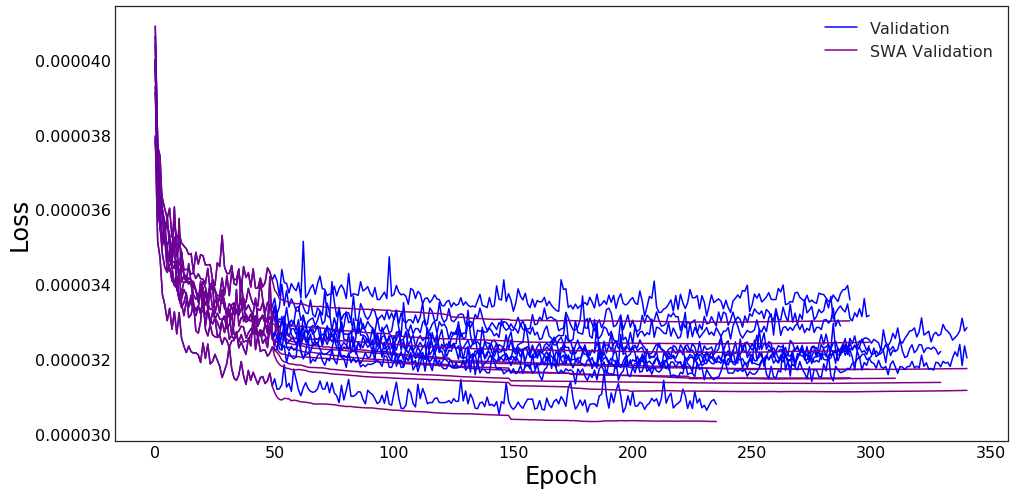

Mean loss = 3.17e-05 +- 2e-07
Mean wAUC = 0.0629 +- 0.0009
Mean AUC = 0.0982 +- 0.0006
______________________________________



<Figure size 432x288 with 0 Axes>

In [9]:
results, histories = _batchTrainClassifier(trainData, nSplits, getModel, modelParams, trainParams, swaStart=50,
                                          patience=50, swaRenewal=25, sgdReplacement=0,
                                          trainOnWeights=True, cosAnnealMult=0, reduxDecay=False,
                                          maxEpochs=maxEpochs, verbose=1)

## Construct ensemble

In [21]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [ ]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

## Response on val data

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = False, reflect = True, augRotMult=16)

In [ ]:
pred = []
for i in xrange(10):
    tmpPred = []
    for aug in range(valData.augMult):
        batch = valData.getTestBatch(i, aug)['inputs']
        tmpPred.append(ensemblePredict(batch, ensemble, weights, n=1))
    pred.append(np.array(tmpPred))

In [ ]:
tPred = np.concatenate(pred, axis=1)

In [ ]:
df = pandas.DataFrame(getFeature('targets', valData.source), columns=['target'])

In [ ]:
for p in xrange(tPred.shape[0]):
    df['pred_'+ str(p)] = tPred[p,:]

In [ ]:
df.loc[:,'pred_mean'] = np.mean(df[[x for x in df.columns if 'pred' in x]], axis=1)

### Rot 8

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### Ref

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 4

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 8

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 10

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 16

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

In [ ]:
def amsScanQuick(inData, wFactor=250000./50000.):
    s = np.sum(inData.loc[inData['gen_target'] == 1, 'gen_weight'])
    b = np.sum(inData.loc[inData['gen_target'] == 0, 'gen_weight'])
    tIIs = inData['pred_class'].argsort()
    amss = np.empty([len(tIIs)])
    
    amsMax = 0
    threshold = 0.0

    for tI in range(len(tIIs)):
        # don't forget to renormalize the weights to the same sum 
        # as in the complete training set
        amss[tI] = AMS(max(0,s * wFactor),max(0,b * wFactor))
        if amss[tI] > amsMax:
            amsMax = amss[tI]
            threshold = inData['pred_class'].values[tIIs[tI]]
            #print tI,threshold
        if inData.loc[:, 'gen_target'].values[tIIs[tI]]:
            s -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
        else:
            b -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
    print amsMax, threshold
    return amsMax, threshold

## Response on validation data base

In [ ]:
valData = BatchYielder(h5py.File(dirLoc + 'val.hdf5', "r+"))

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 4

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=4)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 8

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Ref

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = False, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 4

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=4)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 5

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=5)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 6

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=6)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 8

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=10)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 16

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 16

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 3

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=3)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 5

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=5)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

# Final run

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8),
                     ensembleSize=5, verbose=1)

In [ ]:
saveTest(0.9632657, 'Day_10_basic_rotref8_5')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_basic_rotref8_5_test.csv -m"Day_10 basic rotref8 5"

## Response on validation data Rot-Ref 8 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
cut = amsScanQuick(convertToDF(valData.source))[1]

In [ ]:
trainFrame = pandas.DataFrame()
trainFrame['gen_target'] = getFeature('targets', trainData.source)
trainFrame['gen_weight'] = getFeature('weights', trainData.source)
valFrame = convertToDF(valData.source)

In [ ]:
sigFactor = (len(trainFrame.loc[trainFrame.gen_target == 1, 'gen_weight'])+len(valFrame.loc[valFrame.gen_target == 1, 'gen_weight']))/len(valFrame.loc[valFrame.gen_target == 1, 'gen_weight'])
bkgFactor = (len(trainFrame.loc[trainFrame.gen_target == 0, 'gen_weight'])+len(valFrame.loc[valFrame.gen_target == 0, 'gen_weight']))/len(valFrame.loc[valFrame.gen_target == 0, 'gen_weight'])
print sigFactor, bkgFactor

In [ ]:
def amsScanQuick(inData, sigFactor=250000./50000., bkgFactor=250000./50000.):
    s = np.sum(inData.loc[inData['gen_target'] == 1, 'gen_weight'])
    b = np.sum(inData.loc[inData['gen_target'] == 0, 'gen_weight'])
    tIIs = inData['pred_class'].argsort()
    amss = np.empty([len(tIIs)])
    
    amsMax = 0
    threshold = 0.0

    for tI in range(len(tIIs)):
        # don't forget to renormalize the weights to the same sum 
        # as in the complete training set
        amss[tI] = AMS(max(0,s * sigFactor),max(0,b * bkgFactor))
        if amss[tI] > amsMax:
            amsMax = amss[tI]
            threshold = inData['pred_class'].values[tIIs[tI]]
            #print tI,threshold
        if inData.loc[:, 'gen_target'].values[tIIs[tI]]:
            s -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
        else:
            b -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
    print amsMax, threshold
    return amsMax, threshold

In [ ]:
amsScanQuick(valFrame, sigFactor, bkgFactor)

In [ ]:
def amsScan(inData, scale=False):
    best = [0,-1]
    ams = []
    for index, row in inData.iterrows():
        s = wFactor*np.sum(inData.loc[(inData['pred_class'] >= row['pred_class']) & (inData['gen_target'] == 1), 'gen_weight'])
        b = wFactor*np.sum(inData.loc[(inData['pred_class'] >= row['pred_class']) & (inData['gen_target'] == 0), 'gen_weight'])
        ams.append(AMS(s, b))
        if ams[-1] > best[1]:
            best = [row['pred_class'], ams[-1]]
    print best
    return ams, best

def foldAMSScan(inData, N=10):
    kf = StratifiedKFold(n_splits=N, shuffle=True)
    folds = kf.split(inData, inData['gen_target'])
    bests = []
    for i, (train, test) in enumerate(folds):
        bests.append(amsScan(inData.iloc[test], (np.sum(inData[(inData['gen_target'] == 1)]['gen_weight']), np.sum(inData[(inData['gen_target'] == 0)]['gen_weight'])))[1])
        print "Fold {}, best AMS {} at cut of {}. Total weights Signal:Bkg. {}:{}".format(i, bests[-1][1], bests[-1][0],
                                                                                          np.sum(inData.iloc[test][inData.gen_target == 1]['gen_weight']),
                                                                                          np.sum(inData.iloc[test][inData.gen_target == 0]['gen_weight']))
    print "Mean cut", np.average([x[0] for x in bests], weights=[1/x[1] for x in bests]), "mean AMS", np.average([x[1] for x in bests], weights=[1/x[1] for x in bests])
    return bests

In [ ]:
amsScanQuick(convertToDF(valData.source), 1, 1)

In [ ]:
bests = foldAMSScan(convertToDF(valData.source))

In [ ]:
print np.average([x[0] for x in bests])
print np.average([x[0] for x in bests], weights=[1/x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[1.7448610687361392-x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[1/np.abs(1.7448610687361392-x[1]) for x in bests])

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8),
                     ensembleSize=10, verbose=1)

In [ ]:
saveTest(0.9557010754710975, 'Day_10_M_rotref8_10')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_M_rotref8_10_test.csv -m"Day_10 minus rotref8 10"

## Response on validation data Rot-Ref 16 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=1)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source), 1, 1)

In [ ]:
bests = foldAMSScan(convertToDF(valData.source))

In [ ]:
print 'Mean', np.average([x[0] for x in bests])
print 'Inverse-AMS-weighted mean', np.average([x[0] for x in bests], weights=[1/x[1] for x in bests])
print 'AMS-weighted mean', np.average([x[0] for x in bests], weights=[x[1] for x in bests])
print 'AMS-Difference-weighted mean', np.average([x[0] for x in bests], weights=[1.7472080023156094-x[1] for x in bests])
print 'Inverse AMS-Difference-weighted mean', np.average([x[0] for x in bests], weights=[1/np.abs(1.7472080023156094-x[1]) for x in bests])

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16),
                     ensembleSize=10, verbose=1)

In [ ]:
saveTest(0.95, 'Day_10_95_rotref16_10')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_95_rotref16_10_test.csv -m"Day_10 95 rotref16 10"